# DOCKSTRING figures

## Table of Contents
- [Parity plots](#parity-plots)
- [Bar charts](#bar-charts)
- [CSVs](#csvs)
- [Histograms](#histograms)

**NOTE:** This notebook requires you to have previously run the `process.py` and `collate.py` scripts mentioned in the README

In [3]:
import csv
from pathlib import Path
import pickle
import sys
from typing import Iterable, List, Union

import matplotlib as mpl
from matplotlib import pyplot as plt, patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind_from_stats
from sklearn.metrics import r2_score

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment

sns.set_theme("talk", "white")

DOCKSTRING_PROCESSED_ROOT = Path.home() / "active-projects/molpal-pruning/processed/dockstring"
DOCKSTRING_RUNS_ROOT = Path.home() / "active-projects/molpal-pruning/runs/dockstring"
SIZE = int(260e3)

def retained_idxss(expt: Experiment) -> List[np.ndarray]:
    return [np.load(chkpt / "retained_idxs.npy") for chkpt in expt.chkpts[:-1]]

def total_inference_calls(targets: List[str], split: str, N: int):
    N_calls = []
    for target in targets:
        target_dir = DOCKSTRING_RUNS_ROOT / split / "prune" / target
        n_calls = []
        for expt in target_dir.iterdir():
            expt = Experiment(expt)
            inf_calls = [SIZE, *[float(len(I)) for I in retained_idxss(expt)[:N-1]]]
            n_calls.append(sum(inf_calls))
        N_calls.append(n_calls)

    return np.array(N_calls)

## Parity plots

[back to top](#table-of-contents)

In [4]:
def make_parity_plot(npy_file, N):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7.))

    ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'k--', zorder=0)

    Y = np.load(npy_file)[..., 2]
    Y_f = Y[0]
    Y_p = Y[1]
    _, P = ttest_ind_from_stats(
        Y_p.mean(1), Y_p.std(1), Y_p.shape[1],
        Y_f.mean(1), Y_f.std(1), Y_f.shape[1],
        True,
        "less"
    )
    
    bounds = [0.05]
    cmap = plt.cm.get_cmap("RdPu")
    norm = mpl.colors.BoundaryNorm([0] + bounds + [1], cmap.N)
    
    ax.scatter(
        Y_f.mean(1),
        Y_p.mean(1),
        c=cmap(norm(P*len(P))),
        vmin=0,
        vmax=0.1,
        edgecolors='k',
        zorder=2,
    )

    random = float(split) * N
    ax.scatter(random, random, marker="X", c='grey', edgecolors='k')
    ax.annotate(
        "random\nsearch", (random+0.01, random),
        xytext=(0.2, random+0.05), size="small", ha="center", va="center",
        arrowprops=dict(facecolor='black', shrink=0.05),)

    R2 = r2_score(Y_f.mean(1), Y_p.mean(1))
    ax.text(
        0.2, 0.8, rf"$R^2={R2:0.3f}$",
        va="center", ha="center", bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, ls="--")
    ax.set_xlabel(f"Fraction of Top-250 Scores Found (baseline)")
    ax.set_ylabel(f"Fraction of Top-250 Scores Found (DSP)")

    # cbar = fig.colorbar(
    #     plt.cm.ScalarMappable(norm, cmap),
    #     extend="both",
    #     fraction=0.05,
    #     aspect=30,
    #     label=r"MHC-adjusted $p$-value"
    # )
    # cbar.ax.set_yticks(bounds, labels=bounds)

    fig.tight_layout()
    
    return fig

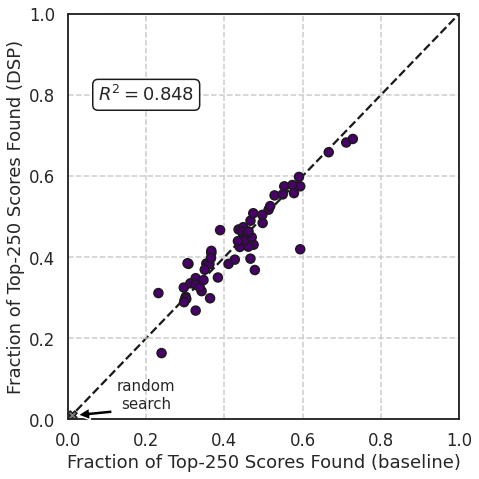

In [3]:
split = "0.001"
N = 10
fig = make_parity_plot(DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-Y.npy", N)
fig.savefig(f"../figures/dockstring-parity-{split}-{N}.pdf", dpi=400)

## Bar charts

[back to top](#table-of-contents)

In [119]:
def make_bar_chart(npy_file, targets_pkl, split: float, N, inference: bool = False):
    WIDTH = 0.65
    FONTSIZE = 10

    fig, ax = plt.subplots(1, 1, figsize=(8.5/2, 11))

    Y = np.load(npy_file)[..., 2]
    targets = pickle.load(open(targets_pkl, "rb"))
    Y_f = Y[0]
    Y_p = Y[1]
    x = np.arange(len(targets))

    idxs = np.argsort(Y_p.mean(1))
    Y_f = Y_f[idxs]
    Y_p = Y_p[idxs]
    targets = [targets[i] for i in idxs]

    _, P = ttest_ind_from_stats(
        Y_p.mean(1), Y_p.std(1), Y_p.shape[1],
        Y_f.mean(1), Y_f.std(1), Y_f.shape[1],
        True,
        "less"
    )
    P *= len(P) # bonferroni MHC correction
    
    if not inference:
        ax.barh(x, Y_p.mean(1), WIDTH, ec='k', lw=2)
        bars = ax.barh(
            x, Y_f.mean(1) - Y_p.mean(1), WIDTH, left=Y_p.mean(1),
            color="none", ec='k', lw=2, hatch="///"
        )
    
        for x_, y_, p in zip(Y_f.mean(1), x, P):
            if p < 0.05:
                ax.text(
                    x_ + 0.02, y_ - 0.3, r"$\ast$",
                    ha="left",
                    # va="bottom",
                    fontsize=FONTSIZE
                )
        # ax.bar_label(
        #     bars,
        #     [r"$\ast$" if p < 0.05 else "" for p in P],
        #     label_type="edge",
        #     padding=6,
        #     fontsize=FONTSIZE
        # )
        ax.axvline(float(split)*(N+1), c="w", lw=1.5, dashes=(3, 1.5),)
        
    else:
        N_calls = total_inference_calls(targets, str(split), N)
        F_calls = N_calls / (SIZE * N)

        bars1 = ax.barh(x + WIDTH/4, Y_p.mean(1), WIDTH/2, ec='k', lw=1, label="performance")
        bars2 = ax.barh(x - WIDTH/4, F_calls.mean(1), WIDTH/2, ec='k', lw=1, label="inference")
        
        ax2 = ax.twiny()
        ax2.set_xlabel("Fraction of Inference Calls", fontsize=FONTSIZE+2)
        ax2.tick_params(axis="x", labelsize=FONTSIZE)
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")

        ax.tick_params(axis="x", color=bars1[0].get_facecolor())
        ax2.tick_params(axis="x", color=bars2[0].get_facecolor())
        
        fig.legend(loc="lower center", ncol=2, fontsize=FONTSIZE, bbox_to_anchor=(0.5, 0.04))
        
    ax.grid(axis="x", ls="--")

    ax.set_xlim(0, 1)
    ax.set_ylim(-WIDTH, x[-1]+WIDTH)

    ax.set_yticks(x, labels=[target.upper() for target in targets], fontsize=10)

    ax.set_xlabel("Fraction of Top-250 Scores Found", fontsize=FONTSIZE+2)
    ax.tick_params(axis="x", labelsize=10)
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
    return fig

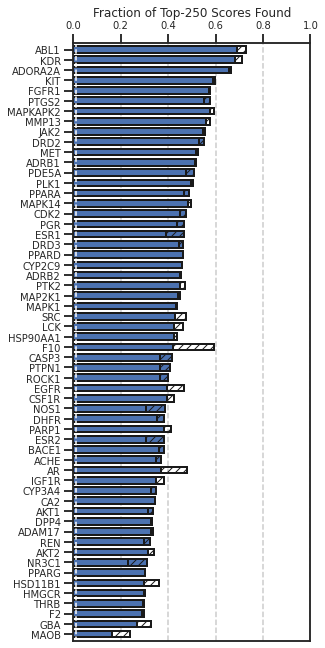

In [122]:
sns.set_style("ticks")

split = "0.001"
N = 10
inference = False

fig = make_bar_chart(
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-Y.npy",
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-targets.pkl",
    float(split),
    N,
    inference
)
# fig.tight_layout()
fig.savefig(
    f"../figures/dockstring/bar{'+inf' if inference else ''}-{split[2:]}.pdf", bbox_inches="tight"
)

## Histograms

```
DOCKSTRING_RUNS_ROOT
├── 0.001
│   ├── prune
│   │   ├── abl1
│   │   │   ├── rep-0 <-- output directory of a MolPAL run
│   │   │  ...
│   │   │   └── rep-N
│   │  ...
│   │   └── thrb
│   └── full
│       ├── abl1
│      ...
│       └── thrb
├── 0.002
|   ├── prune
│   └── full
└── 0.004
```

Text(0.5, 0, 'Fraction of inference calls')

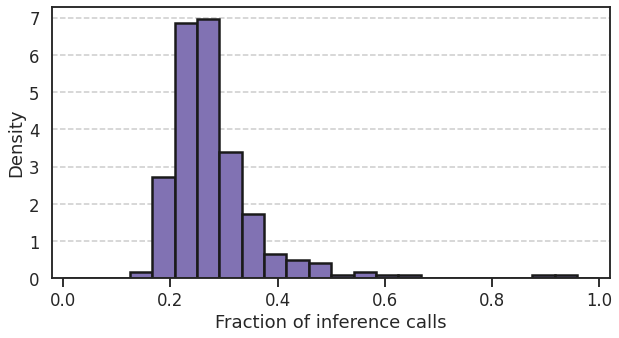

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

targets = pickle.loads(
    (Path.home() / "active-projects/molpal-pruning/processed/dockstring/collated-0.004-targets.pkl")
    .read_bytes()
)
split = "0.002"
N = 8

N_calls = total_inference_calls(targets, split, N)
F_calls = N_calls / (SIZE * N)

x, y, _ = ax.hist(
    F_calls, np.linspace(0, 1, 25), lw=2.5, density=True, color="m", ec="k",
    label=f"{float(split):0.1%}"
)

ax.set_xlim(-0.02, 1.02)
ax.tick_params(axis="x", which="major", bottom=True)
ax.grid(True, which="both", axis="y", ls="--")

ax.set_ylabel("Density")
ax.set_xlabel("Fraction of inference calls")

In [88]:
fig.savefig(f"../figures/dockstring-{split[2:]}-calls-hist.pdf", bbox_inches="tight")

## CSVs

[back to top](#table-of-contents)

In [8]:
def make_dataframe(npy_file, targets_pkl, split, N) -> pd.DataFrame:
    Y = np.load(npy_file)[..., 2]
    targets = pickle.load(open(targets_pkl, "rb"))
    Y_f = Y[0]
    Y_p = Y[1]
    
    N_calls = total_inference_calls(targets, split, N)
    F_calls = N_calls / (SIZE * N)
    df = pd.DataFrame(
        {
            "target": [t.upper() for t in targets],
            "baseline (mean)": Y_f.mean(1),
            "baseline (s.d.)": Y_f.std(1),
            "DSP (mean)": Y_p.mean(1),
            "DSP (s.d.)": Y_p.std(1),
            "relative inference calls (mean)": F_calls.mean(1),
            "relative inference calls (s.d.)": F_calls.std(1)
        },
    )

    return df

In [12]:
split = "0.001"
N = 10
df = make_dataframe(
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-Y.npy",
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-targets.pkl",
    split,
    N
)
df.to_csv(f"../csv/dockstring-perf+calls-{split[2:]}.csv", index=False, float_format="%.3f")
df


/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")


,target,baseline (mean),baseline (s.d.),DSP (mean),DSP (s.d.),relative inference calls (mean),relative inference calls (s.d.)
0,CYP3A4,0.3264,0.021407,0.3480,0.044971,0.180850,0.027280
1,ADRB2,0.4480,0.035236,0.4528,0.021967,0.252352,0.026159
2,SRC,0.4744,0.024864,0.4304,0.061792,0.184467,0.020734
3,AKT1,0.3128,0.062962,0.3352,0.032732,0.376004,0.074388
4,ADORA2A,0.6664,0.014881,0.6584,0.007419,0.157126,0.027649
5,DHFR,0.3536,0.042453,0.3840,0.016589,0.199696,0.018452
6,PPARA,0.4664,0.030735,0.4896,0.013529,0.365707,0.069848
7,MAPKAPK2,0.5936,0.027317,0.5744,0.027317,0.192925,0.018848
8,EGFR,0.4664,0.128614,0.3960,0.036133,0.255222,0.035045
9,PGR,0.4360,0.044686,0.4680,0.047531,0.382623,0.026198


In [14]:
total_inference_calls(["maob"], "0.004", 5)

/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")


array([[ 962973., 1083609.,  969733.,  798405.,  853508.]])

## Miscellaneous

In [ ]:
def make_prune_example(
    seed: int = 0, hit_cutoff: float = 1.0, prune_cutoff: float = 0., prob: bool = False
):
    np.random.seed(seed)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params("y", direction="inout", left="on")

    ax.set_ylabel(r"$\hat{y}$")
    ax.set_xlabel("Candidates")

    x = np.linspace(0, 1, 6)
    y_pred = np.random.normal(0, 2, size=len(x))
    y_sd = np.random.uniform(2, 2.5, size=len(x))

    ax.scatter(
        x, y_pred, c=y_pred, cmap="RdBu_r", edgecolors="k", linewidths=1.0, zorder=10
    )
    if not prob:
        ax.errorbar(x, y_pred, y_sd, capsize=3, capthick=2., ls="None", c="grey")
    else:
        data = [np.random.normal(m, sd, 10000) for m, sd in zip(y_pred, y_sd)]
        violin = ax.violinplot(
            data,
            x,
            True,
            widths=0.1,
            showmeans=False,
            showextrema=False,
            showmedians=False,
        )
        for pc in violin["bodies"]:
            pc.set_facecolor("m")
            pc.set_edgecolor("k")

    # hit_cutoff = 1.425
    ax.axhline(hit_cutoff, linestyle="--", c="r")
    ax.annotate(
        "predicted hit\nthreshold",
        xy=(0.52, hit_cutoff),
        xytext=(0.59, hit_cutoff + 3.75),
        arrowprops=dict(facecolor="black", shrink=0.05),
        wrap=True
    )

    if not prob:
        ax.axhline(prune_cutoff, linestyle="--", c="b")
        ax.annotate(
            "prune cutoff",
            xy=(0.8, prune_cutoff),
            xytext=(0.75, prune_cutoff+1.5),
            arrowprops=dict(facecolor="black", shrink=0.05),
            horizontalalignment="center",
            verticalalignment="bottom",
        )
        
    return fig


In [ ]:
make_prune_example(6, 3, prob=True).savefig("../figures/pruning/prune-prob-ex.pdf")

In [13]:
def get_target_scores(dockstring_csv: Union[str, Path], target: str):
    with open(dockstring_csv) as fid:
        reader = csv.reader(fid)
        i = next(reader).index(target)
        ys = [float(row[i]) for row in reader if row[i]]

    return np.array(ys)

In [225]:
DOCKSTRING_CSV = Path.home() / "molpal/data/dockstring-data.csv"

def plot_score_hist(ys: Iterable[float], k: int = 250, length = None):
    sns.set_palette("pastel")
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    y = get_target_scores(DOCKSTRING_CSV, target.upper())

    _, bins, _ = ax.hist(y, 75, ec="k", align="mid")

    t = np.sort(y)[k]
    ax.axvline(t, color="r", ls=":")

    ax.set_yscale("log")

    y = np.floor(np.log10(ax.get_ylim()[1]))
    length = length or (t - bins[0])
    ax.arrow(
        x=t, y=10**(y-0.5), dx=-length, dy=0, width=10**(y-1.7), head_length=0.2*length, head_width=10**(y-1), length_includes_head=True, color="r"
    )

    ax.set_ylabel("Count")
    ax.set_xlabel("Score")

    ax.grid(axis="y", ls="--")
    ax.tick_params(axis="x", which="major", bottom=True)

    fig.tight_layout()

    return fig


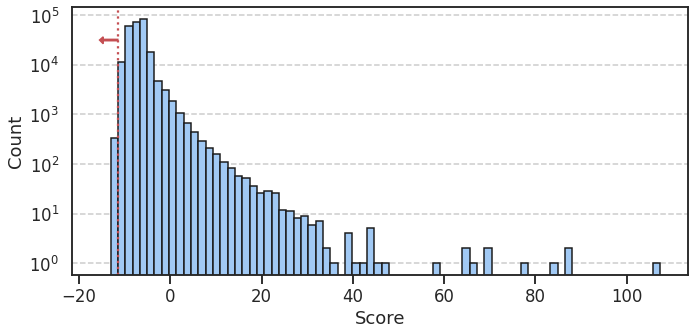

In [227]:
target = "maob"
fig = plot_score_hist("maob", 250, 4)
fig.savefig(f"../figures/dockstring-{target}-score-hist.pdf", bbox_inches="tight")